# Programming Exercise 4: Neural Networks Learning
*Code's author: Natália Tenório Maia*<br>
*Solution for [Exercise 4](https://www.coursera.org/learn/machine-learning/home/week/5) of Coursera's Machine Learning course by Andrew Ng.*
<br>
<br>
There are many different ways to solve this exercise. Here you will learn just one possible way, where I tried to stick with the original idea proposed in the exercise's pdf.
<br>
<br>
In this exercise, you will implement the backpropagation algorithm for neural networks (NN) and apply it to the task of hand-written digit recognition.

## Part 1 - Neural Networks
In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network.
 <br>
**Goal:** Implement the backpropagation algorithm to learn the parameters for the neural network.
<br>
### Importing data

In [1]:
import numpy as np                  # package for scientific computing
import matplotlib.pyplot as plt     # plotting library
from scipy import optimize as opt   # package for optimizing functions
from scipy.io import loadmat        # package for reading MatLab files
import copy                         # package for shallow and deep copy operations

dataset = loadmat('ex4data1.mat')

X = dataset['X']         # input training set
y = dataset['y'].ravel() # output training set
m = X.shape[0]           # number of examples
n = X.shape[1]           # number of features
K = len(np.unique(y))    # number of classes
y[y==10]=0               # fixing the values related to the number 0, since 0 is a valid index in Python.

datatheta = loadmat('ex4weights.mat')
Theta1 = datatheta['Theta1'].T
# For Theta2, which takes the hidden layer to the output layer, we have to swap the first and
# the last columns because we are not using the number "10" for indexing but "0":
Theta2 = np.roll(datatheta['Theta2'], 1, axis=0).T
# All parameters organized as a list:
NN_Theta = np.concatenate((Theta1.ravel(), Theta2.ravel()))

# Number of units in each layer in the NN:
L1_size = X.shape[1]        # 20x20 pixels
L2_size = Theta1.shape[1]   # 25 hidden units
L3_size = K                 # 10 classes (0 to 9)

### Visualizing data

You will begin by visualizing a random subset of the training set.

In [2]:
# This displays data stored in X in a 2D grid:
def displaydata(X, figsize):
    # Determines the number of rows, cols of the entire figure:
    if X.ndim == 2:
        m, n = X.shape   
    elif X.ndim == 1:
        m = 1; n = X.size
        X = X[None]     # this command transforms X into a 1xn array
    else:
        raise IndexError('The input X should be a 1 or 2 dimensional numpy array.')
    # For each individual example to be displayed, we have to determine its dimensions:
    ex_width = int(np.round(np.sqrt(n))); ex_height = int(np.round(n/ex_width))        
    # Determines the number of items to be displayed in the figure:
    fig_rows = int(np.floor(np.sqrt(m))); fig_cols = int(np.ceil(m /fig_rows))
    # Creates a figure (fig) with an array (ax_array) of subplots:
    fig, ax_array = plt.subplots(fig_rows, fig_cols, figsize=figsize)
    # Adjusts spacing between subplots:
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()
    for i in range(len(ax_array)):
        ax_array[i].imshow(X[i].reshape(ex_width, ex_height, order='F'),cmap='GnBu'); ax_array[i].axis('off')

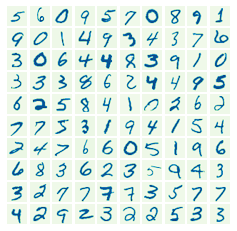

In [3]:
# Now we randomly select 100 of the 5000 rows in the input training dataset:
rand = np.random.choice(m, 100, replace=False)
rand_data = X[rand, :]
# Here we display the 100 numbers encoded in these selected data:
displaydata(rand_data,(4,4))

### Model representation

Our neural network is shown below.

For this case, we will use a NN with 3 layers:<br>
$a^{(1)}$: input layer $a^{(1)}=X_{5000\times401}$ with parameters $\Theta^{(1)}_{401\times25}$ ;<br>
$a^{(2)}$: hidden layer $a^{(2)}=g(a^{(1)} \Theta^{(1)})_{5000\times26}$ wtih parameters $\Theta^{(2)}_{26\times10}$;<br>
$a^{(3)}$: output layer $a^{(3)}=g(a^{(2)} \Theta^{(2)})_{5000\times10}$.<br>

This is the architecture of the NN we will build:
<br>
<img src="NN.png" width="320"/>
<br>
OBS: The +1 refers to the bias units related to the input and the hidden layers.

### Regularized cost function

Now you will implement the cost function and its gradient, in order to train our NN.

#### Feedforward propagation

We will first implement feedforward propagation to calculate the layers $a^{(1)},a^{(2)},a^{(3)}$, where the hypothesis is $h_{\Theta}=a^{(3)}$, using the given $\Theta^{(1)},\Theta^{(2)}$. Then, we will use this initial NN to compute the *cost function*, which is given by:<br>

$
J\left(\Theta\right)=-\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\left[y_{k}^{\left(i\right)}log\left(h_{\Theta}\left(x^{\left(i\right)}\right)_{k}\right)+\left(1-y_{k}^{\left(i\right)}\right)log\left(1-h_{\Theta}\left(x^{\left(i\right)}\right)_{k}\right)\right]+\frac{\lambda}{2m}\sum_{l=1}^{L-1}\sum_{i=1}^{s_{l}}\sum_{j=1}^{s_{l+1}}\left(\Theta_{ij}^{\left(l\right)}\right)^{2}.
$

where $s_{l}$ is number of units in layer $l$ **excluding** the bias unit. So, for our NN we have: <br>
$s_{1}=400$;<br>
$s_{2}=25$;<br>
$s_{3}=10$.<br>

We need to pay attention to the limits of the sum in the cost function equation when translating them to Python language. In the mathematical representation used in that equation, $1$ is considered to be the lowest number which the counting can start. For instance: having in mind that $m=5000$, we sum from example 1 up to example 5000, and not from example 0 to example 4999. But in Python, the lowest counting element is 0, not 1. 

Now notice that, in the regularization term, we do not regularize the bias node. For instance, for $l=1$ we have $s_{1}=400$ but $\Theta^{(1)}_{401\times25}$, in which the row dimension $401$ already includes the bias node related to the input layer bias unit $a^{(1)}_{0}=x_{0}$, but the column dimension $25$ excludes the bias unit $a^{(2)}_{0}$ of the next layer; because of that, we will be summing in $i$ in Python from 1 up to 401 (and not from 0 up to 401), while we will be summing in $j$ from 0 up to 25. In other words, we will sum the squared elements of $\Theta$ excluding the zeroth row (which is related to the bias units) and including all columns.

To train our NN for this multi-class problem, we are going to rewrite the output training set as shown below:

$
y_{5000\times1}=\left(\begin{array}{c}
\vdots\\
4\\
5\\
\vdots
\end{array}\right)\rightarrow Y_{5000\times10}=\left(\begin{array}{c}
\vdots\\
0\,0\,0\,0\,1\,0\,0\,0\,0\,0\,0\\
0\,0\,0\,0\,0\,1\,0\,0\,0\,0\,0\\
\vdots
\end{array}\right)
$

The feedforward propagation will automatically give us the hypothesis in the format $H_{5000\times10}$ (which is the output layer $a^{(3)}$), as we can see below. Notice that, differently from $Y$, the hypothesis $H$ won't be given in terms of 0s and 1s, but in terms of fractional numbers ranging from 0 to 1.

#### Backpropagation

We will use backpropagation to compute the *gradient of the cost function*, which can be described by the following steps:<br>
1 - $\delta^{(L)}=a^{(L)}-y^{(i)}$ and then $\delta^{(l)}=\left(\delta^{(l+1)}\Theta^{(l)*}\right)\circ\left(a^{(l)*}\circ\left(1-a^{(l)*}\right)\right)$  for $l \neq L$;<br>
2 - $\Delta^{(l)}=\left(a^{(l)}\right)^{T}\delta^{(l+1)}$; <br>
3 - $D_{ij}^{(l)}:=\frac{1}{m}\Delta_{ij}^{(l)}+\lambda\Theta_{ij}^{(l)}$
if $i\neq0$, and $D_{ij}^{(l)}:=\frac{1}{m}\Delta_{ij}^{(l)}$ if
$i=0$ .



Then, the gradient is given by $\left( \frac{\partial J}{\partial \Theta^{(l)}}\right) = D^{(l)}$ .

OBS 1: The operation $\circ$ in step 1 is the Hadamard product, also called element wise multiplication, which consists of multiplying each element of a matrix by the corresponding element of another matrix of the same dimensions.<br>
OBS 2: The $*$ in the activation functions in step 1 is to indicate that in order to compute the error functions $\delta^{(l)}$ and $\Delta^{(l)}$, we do not take into account the bias unit of neither the activation functions $a^{(l)}$ nor the parameters $\Theta^{(l)}$ . For instance, while $a^{(2)}$ is a $5000\times26$ matrix, $a^{(2)*}$ is a $5000\times25$ matrix because it excludes the bias unit $a^{(2)}_{0}$; similarly, while $\Theta^{(2)}$ is a $26\times10$ matrix, $\Theta^{(2)*}$ is a $25\times10$ matrix because it excludes the row $\Theta^{(2)}_{0i}$.

In [4]:
# Simplified matrix multiplication command:
def MM(A,B):
    return np.matmul(A,B)

# Sigmoid function:
def g(Theta,X):
    return 1/(1+np.exp(-MM(X,Theta)))

# Cost function:
def NN_costfunction(NN_Theta,X,y,lamb):
    m = len(y) # number of examples
    # Gets the parameters back to their original shapes:
    Theta1 = np.reshape( NN_Theta[:L2_size*(L1_size+1)],((L1_size+1),L2_size) )
    Theta2 = np.reshape( NN_Theta[L2_size*(L1_size+1):],((L2_size+1),L3_size) )

    # Feedforward propagation --------------------------------------------------------------------------------------
    
    a1 = X
    a2 = g(Theta1,a1) ; a2=np.append(np.ones((len(a2),1)),a2,axis=1) ;
    a3 = g(Theta2,a2)
          
    # Hypothesis and output training set 5000x10 matrices:
    H = a3
    Y = np.zeros((len(y),K))
    for i in range(m):
        Y[i][y[i]]=1
    # Hypothesis and output sets organized as lists of size=5000*10 and reshaped into column vectors:
    h_all = np.array([H.ravel()]).reshape(-1,1)
    y_all = np.array([Y.ravel()]).reshape(-1,1)
    
    # Cost:
    reg = (lamb/(2*m))*( (Theta1[1:]**2).sum() + (Theta2[1:]**2).sum() )
    J = -(1/m)*( MM(y_all.T,np.log(h_all)) + MM((1-y_all.T),np.log(1-h_all)) ) + reg ; J = float(J.flatten());
    
    # Backpropagation ----------------------------------------------------------------------------------------------
    
    delta3 = a3-Y 
    delta2 = MM(delta3,Theta2[1:].T)*(a2[:,1:]*(1-a2[:,1:]))
    Delta1 = MM(a1.T,delta2)
    Delta2 = MM(a2.T,delta3)
    Theta1mod = copy.deepcopy(Theta1); Theta1mod[0]=0
    Theta2mod = copy.deepcopy(Theta2); Theta2mod[0]=0
    
    D1 = (1/m)*(Delta1 + lamb*Theta1mod)
    D2 = (1/m)*(Delta2 + lamb*Theta2mod)
    
    # Gradient:
    grad = np.concatenate((D1.ravel(), D2.ravel()))

    return J, grad

In [5]:
X = dataset['X']; X = np.append(np.ones((m,1)), X,axis=1); # adds bias units

J0 = NN_costfunction(NN_Theta,X,y,0)[0]
J1 = NN_costfunction(NN_Theta,X,y,1)[0]
J2 = NN_costfunction(NN_Theta,X,y,3)[0]
print(round(J0,6),round(J1,6),round(J2,6))

0.287629 0.38377 0.576051


The results above show the cost for $\lambda=0$, $\lambda=1$ and $\lambda=3$, which agree with what is shown in the files ex4.pdf and ex4.m.

### Random Initialization

It's important to guarantee that the initial values of the NN parameters are not identical in order to have a NN that is effective. One strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init},\epsilon_{init}]$.<br>
Usually, a good choice for $\epsilon_{init}$ is:<br>
$\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in}+L_{out}}}$,<br>
where $L_{in}$ and $L_{out}$ are the number of units in the layers adjacent to $\Theta^{(l)}$. For this exercise, we will just use $\epsilon_{init}=0.12$.

In [6]:
def randInitializeWeights(L_in,L_out,epsilon_init):
    W = np.zeros((L_in+1,L_out))
    W = np.random.rand(L_in+1,L_out)*2*epsilon_init - epsilon_init
    return W

rand_Theta1 = randInitializeWeights(L1_size,L2_size,0.12)
rand_Theta2 = randInitializeWeights(L2_size,L3_size,0.12)

rand_NN_Theta = np.concatenate((rand_Theta1.ravel(), rand_Theta2.ravel()))

In [7]:
rand_NN_Theta

array([-0.09496247,  0.09542083,  0.09883262, ...,  0.08448706,
        0.11305165,  0.09671665])

### Checking gradient

We want to check that the gradient of the cost function that we computed earlier, which is left handside of the expression below, is approximatey the same as the numerical gradient of the cost function, which in turn is the right handside of the relation below:
$$ \frac{\partial}{\partial \theta_i} J(\theta) \approx \frac{J\left( \theta^{(i+)}\right) - J\left( \theta^{(i-)} \right)}{2\epsilon} $$<br>
where<br>
$$\theta^{(i+)}\equiv\left(\begin{array}{c}
\theta_{1}\\
\vdots\\
\theta_{i}+\epsilon\\
\vdots\\
\theta_{n}
\end{array}\right),$$<br>
and similarly for $\theta^{(i-)}$, but subtracting $\epsilon$ instead of adding it.

#### Computing gradient numerically

In [8]:
def checking_grad(rand_NN_Theta,X,y,lamb):
    Theta = copy.deepcopy(rand_NN_Theta)
    epsilon = 10**(-4)
    num_grad = np.zeros(len(Theta))

    for i in range(len(Theta)):
        Thetaplus=copy.deepcopy(Theta); Thetamin=copy.deepcopy(Theta);
        Thetaplus[i] = Thetaplus[i] + epsilon
        Thetamin[i] = Thetamin[i] - epsilon
        Jplus = NN_costfunction(Thetaplus,X,y,lamb)[0]
        Jmin = NN_costfunction(Thetamin,X,y,lamb)[0]
        num_grad[i] = (Jplus - Jmin) / (2*epsilon)
    
    J, grad = NN_costfunction(Theta,X,y,lamb)
    diff = np.linalg.norm(num_grad - grad)/np.linalg.norm(num_grad + grad)
    
    print("Regularization parameter = "+str(lamb))
    print("Numerical gradient:"); print(num_grad)
    print("Analytical gradient:"); print(grad)
    print("Relative difference: "+str(diff))

<font color='red'><b>OBS:</b></font> It might take a few minutes to run the two cells below.

In [9]:
checking_grad(rand_NN_Theta,X,y,0)

Regularization parameter = 0
Numerical gradient:
[ 0.02809168  0.0249114  -0.00128725 ...  0.18742258  0.2208864
  0.20006721]
Analytical gradient:
[ 0.02809168  0.0249114  -0.00128725 ...  0.18742258  0.2208864
  0.20006721]
Relative difference: 8.489129565568075e-11


In [10]:
checking_grad(rand_NN_Theta,X,y,3)

Regularization parameter = 3
Numerical gradient:
[ 0.02809168  0.0249114  -0.00128725 ...  0.18747327  0.22095423
  0.20012524]
Analytical gradient:
[ 0.02809168  0.0249114  -0.00128725 ...  0.18747327  0.22095423
  0.20012524]
Relative difference: 9.146868678974556e-11


Since the relative difference between the gradients is less than $10^{-9}$, our NN implementation has been sucessful.

### Learning parameters using scipy.optimize.minimize

In [11]:
initial_theta = rand_NN_Theta
lamb = 1

optmin = opt.minimize(NN_costfunction,initial_theta,(X,y,lamb),jac=True,method='TNC',options={'maxiter': 100})

J = optmin.fun
Theta = optmin.x
# Gets the parameters back to their original shapes:
Theta1 = np.reshape( NN_Theta[:L2_size*(L1_size+1)],((L1_size+1),L2_size) )
Theta2 = np.reshape( NN_Theta[L2_size*(L1_size+1):],((L2_size+1),L3_size) )

In [12]:
J, Theta

(0.48503908557288866,
 array([ 0.70173596,  0.10880191, -0.50399633, ..., -0.24444214,
        -1.81518273,  1.74306501]))

### Prediction

In [13]:
def prediction(Theta,X):
    Theta1 = np.reshape( Theta[:L2_size*(L1_size+1)],((L1_size+1),L2_size) )
    Theta2 = np.reshape( Theta[L2_size*(L1_size+1):],((L2_size+1),L3_size) )
    a1 = X
    a2 = g(Theta1,a1) ; a2=np.append(np.ones((len(a2),1)),a2,axis=1) ;
    a3 = g(Theta2,a2)
    H = a3
    pred = np.array([int(np.where(H[i] == H[i].max())[0]) for i in range(len(H))])
    return pred

In [14]:
p = prediction(Theta,X)
np.mean(p==y)

0.958

According to ex4.pdf, the expected accuracy is 95.3%. Since our accuracy is 96%, we can be satisfied with the implementation of our NN.

### Optional (ungraded) exercise

In this part of the exercise, you will get to try out different learning settings for the neural network to see how the performance of the neural network varies with the regularization parameter λ and number of training steps (the MaxIter option when using scipy.optimize.minimize).

In [15]:
def accuracy(lamb,MxIt):
    option = {'maxiter': MxIt}
    optmin = opt.minimize(NN_costfunction,initial_theta,(X,y,lamb),jac=True,method='TNC',options=option)
    Theta = optmin.x
    p = prediction(Theta,X)
    acc = np.mean(p==y)
    return round(acc*100,2)

In [16]:
print("lamb = 0")
print(accuracy(0,20),accuracy(0,100),accuracy(0,200))
print("lamb = 0.5")
print(accuracy(0.5,20),accuracy(0.5,100),accuracy(0.5,200))
print("lamb = 1")
print(accuracy(1,20),accuracy(1,100),accuracy(1,200))
print("lamb = 10")
print(accuracy(10,20),accuracy(10,100),accuracy(10,200))
print("lamb = 50")
print(accuracy(50,20),accuracy(50,100),accuracy(50,200))
print("lamb = 100")
print(accuracy(100,20),accuracy(100,100),accuracy(100,200))

lamb = 0
40.22 94.56 99.52
lamb = 0.5
40.16 95.84 99.58
lamb = 1
40.14 95.8 99.1
lamb = 10
31.62 92.72 94.0
lamb = 50
25.38 88.62 89.04
lamb = 100
55.24 84.78 84.82


The results above illustrate how the accuracy changes when we increase the number of iterations, for a fixed value of the regularization parameter.
* The number of iterations necessary to approach the highest accuracy varies with the choice of the regularization parameter. Therefore, the regularization parameter not only helps prevent overfitting and underfitting, but it can also improve the NN efficiency.

* The accuracy decreseas as the regularization parameter increases, as expected, since the idea is to prevent overfitting. But we also see that if the regularization parameter is too large, the accuracy starts getting smaller and smaller, which is related to underfitting. Therefore, regularization needs to be handled carefully in order to optimize our NN, by avoiding both overfitting and underfitting.

End of exercise 4.

# Appendix

At the beginning of this code, we imported the *copy module* to avoid the problem shown below:

In [17]:
A = np.array([[1,2,3],[4,5,6]])
B = A
B[0] = 0
A

array([[0, 0, 0],
       [4, 5, 6]])

In [18]:
A = np.array([[1,2,3],[4,5,6]])
B = copy.deepcopy(A)
B[0] = 0
A

array([[1, 2, 3],
       [4, 5, 6]])

This is related to the concept of reference. All objects in Python have a reference and when we assign one to two names A and B, this results in both A and B pointing to the same object. <br>
By using copy.deepcopy() we can modify B in any way without modifying A.